# Create a feature engineering pipeline

In Section 1, you tabularized a sales time series dataset to forecast sales for the next week.

In this assignment, your task is to line up those feature engineering steps within a pipeline to directly obtain the features from the input data and then forecast sales using Lasso.

The most straightforward method is probably to use the open-source library Feature-engine. But you are welcome to use other libraries, code your transformers manually, or, why not, code our own pipeline?

To prepare the dataset for this assignment, please follow the guidelines in the notebook `02-create-online-retail-II-datasets.ipynb` in the `01-Create-Datasets` folder.

In [1]:
!pip install feature-engine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.4/319.4 kB 12.1 MB/s eta 0:00:00


In [2]:
# imports

import pandas as pd
from feature_engine.creation import CyclicalFeatures
from feature_engine.datetime import DatetimeFeatures
from feature_engine.imputation import DropMissingData
from feature_engine.selection import DropFeatures
from feature_engine.timeseries.forecasting import (
    LagFeatures,
    WindowFeatures
)
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso

<h2><font face='Comic Sans MS' color='darkblue'><strong> Section 1<font color='blue'>  tabularizing a sales time series dataset to forecast sales for the next week

In [3]:
# load weekly sales dataset

# Adjust the following function based on where 
# you stored the dataset
#filename = "../../../Datasets/online_retail_dataset.csv"
filename = "/content/online_retail_dataset.csv"

df = pd.read_csv(
    filename,
    usecols=["week", "United Kingdom"],
    parse_dates=["week"],
    index_col=["week"],
)

df.columns = ['sales']

df.head()

,sales
week,
2009-12-06,213000.35
2009-12-13,195810.04
2009-12-20,182396.74
2009-12-27,22007.77
2010-01-03,0.00


## Plot time series

<Axes: xlabel='week'>

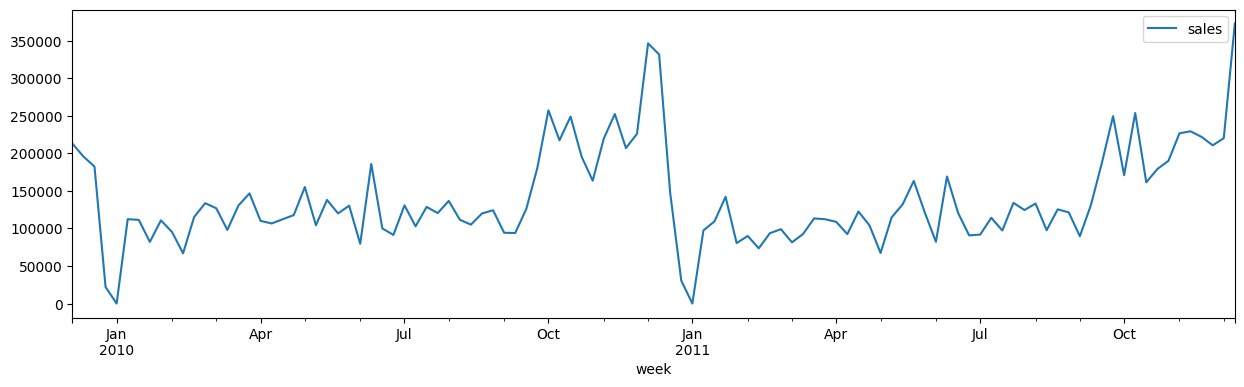

In [4]:
df.plot(figsize=[15, 4])

## Feature engineering

These are the feature engineering steps that you need to fit into a pipeline:

- Datetime features: Create the feature **month** from the timestamp.
- Cyclical features: transform the month with the sine and cosine functions.
- Lag features: Create the feature lag-1 by lagging 1 week of data.
- Window features: take the min, max and average sales values in the past 2 and 4 weeks of data.
- Drop missing data.

First set up suitable transformers / transformations and make sure they work.

In [5]:
# Create the feature month from the timestamp.

df["month"] = df.index.month

In [6]:
df.isnull().sum()

sales    0
month    0
dtype: int64

In [7]:
# Transform the month with the sine and cosine functions

cyclic = CyclicalFeatures(
    variables=['month'],
    drop_original=False
)

df = cyclic.fit_transform(df)

In [8]:
df.head()

,sales,month,month_sin,month_cos
week,,,,
2009-12-06,213000.35,12,-2.449294e-16,1.000000
2009-12-13,195810.04,12,-2.449294e-16,1.000000
2009-12-20,182396.74,12,-2.449294e-16,1.000000
2009-12-27,22007.77,12,-2.449294e-16,1.000000
2010-01-03,0.00,1,5.000000e-01,0.866025


In [9]:
# Create the feature lag-1 by lagging 1 week of data.

variables = ['sales']

temp = df[variables].shift(freq='W')

temp.columns = [var + '_lag_1' for var in variables]

df = df.merge(temp, left_index=True, right_index=True, how='right')

In [10]:
df.head()

,sales,month,month_sin,month_cos,sales_lag_1
week,,,,,
2009-12-13,195810.04,12.0,-2.449294e-16,1.000000,213000.35
2009-12-20,182396.74,12.0,-2.449294e-16,1.000000,195810.04
2009-12-27,22007.77,12.0,-2.449294e-16,1.000000,182396.74
2010-01-03,0.00,1.0,5.000000e-01,0.866025,22007.77
2010-01-10,112318.85,1.0,5.000000e-01,0.866025,0.00


In [11]:
# Here we take the average, maximum, and minimum values
# of the previous 2 and 4 weeks.

variables=['sales']

temp_2W_avg = df[variables].rolling(2).mean().shift(freq='1W')

temp_2W_avg.columns = [v +'_window_2W_avg' for v in variables]

temp_4W_avg = df[variables].rolling(4).mean().shift(freq='1W')

temp_4W_avg.columns = [v +'_window_4W_avg' for v in variables]

temp_2W_max = df[variables].rolling(2).max().shift(freq='1W')

temp_2W_max.columns = [v +'_window_2W_max' for v in variables]

temp_4W_max = df[variables].rolling(4).max().shift(freq='1W')

temp_4W_max.columns = [v +'_window_4W_max' for v in variables]

temp_2W_min = df[variables].rolling(2).min().shift(freq='1W')

temp_2W_min.columns = [v +'_window_2W_min' for v in variables]

temp_4W_min = df[variables].rolling(4).min().shift(freq='1W')

temp_4W_min.columns = [v +'_window_4W_min' for v in variables]

In [12]:
dfs = [temp_2W_avg, temp_4W_avg, temp_2W_max, temp_4W_max, temp_2W_min, temp_4W_min]

temp = pd.concat(dfs, join='outer', axis=1)

In [13]:
temp.head()

,sales_window_2W_avg,sales_window_4W_avg,sales_window_2W_max,sales_window_4W_max,sales_window_2W_min,sales_window_4W_min
week,,,,,,
2009-12-20,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-27,189103.390,NaN,195810.04,NaN,182396.74,NaN
2010-01-03,102202.255,NaN,182396.74,NaN,22007.77,NaN
2010-01-10,11003.885,100053.6375,22007.77,195810.04,0.00,0.0
2010-01-17,56159.425,79180.8400,112318.85,182396.74,0.00,0.0


In [14]:
temp.shape, df.shape

((106, 6), (106, 5))

In [15]:
# lets merge window features with the dataset

df = df.merge(temp, left_index=True, right_index=True, how='right')

In [16]:
df.head()

,sales,month,month_sin,month_cos,sales_lag_1,sales_window_2W_avg,sales_window_4W_avg,sales_window_2W_max,sales_window_4W_max,sales_window_2W_min,sales_window_4W_min
week,,,,,,,,,,,
2009-12-20,182396.74,12.0,-2.449294e-16,1.000000,195810.04,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-27,22007.77,12.0,-2.449294e-16,1.000000,182396.74,189103.390,NaN,195810.04,NaN,182396.74,NaN
2010-01-03,0.00,1.0,5.000000e-01,0.866025,22007.77,102202.255,NaN,182396.74,NaN,22007.77,NaN
2010-01-10,112318.85,1.0,5.000000e-01,0.866025,0.00,11003.885,100053.6375,22007.77,195810.04,0.00,0.0
2010-01-17,111460.47,1.0,5.000000e-01,0.866025,112318.85,56159.425,79180.8400,112318.85,182396.74,0.00,0.0


In [17]:
# Drop missing data.

df.isnull().sum(), df.isnull().sum() / len(df)

(sales                  2
 month                  2
 month_sin              2
 month_cos              2
 sales_lag_1            1
 sales_window_2W_avg    2
 sales_window_4W_avg    4
 sales_window_2W_max    2
 sales_window_4W_max    4
 sales_window_2W_min    2
 sales_window_4W_min    4
 dtype: int64,
 sales                  0.018868
 month                  0.018868
 month_sin              0.018868
 month_cos              0.018868
 sales_lag_1            0.009434
 sales_window_2W_avg    0.018868
 sales_window_4W_avg    0.037736
 sales_window_2W_max    0.018868
 sales_window_4W_max    0.037736
 sales_window_2W_min    0.018868
 sales_window_4W_min    0.037736
 dtype: float64)

In [18]:
print("data size before na treatement :")
print(df.shape)

df.dropna(inplace=True)                   # Dropping missing data

print("\ndata size after na treatement :")
print(df.shape)

data size before na treatement :
(106, 11)

data size after na treatement :
(101, 11)


In [19]:
# Drop original time series

drop_og_ts = DropFeatures(features_to_drop=['sales'])
df = drop_og_ts.fit_transform(df)
df.head()

,month,month_sin,month_cos,sales_lag_1,sales_window_2W_avg,sales_window_4W_avg,sales_window_2W_max,sales_window_4W_max,sales_window_2W_min,sales_window_4W_min
week,,,,,,,,,,
2010-01-10,1.0,0.500000,0.866025,0.000,11003.8850,100053.63750,22007.770,195810.04,0.000,0.000
2010-01-17,1.0,0.500000,0.866025,112318.850,56159.4250,79180.84000,112318.850,182396.74,0.000,0.000
2010-01-24,1.0,0.500000,0.866025,111460.470,111889.6600,61446.77250,112318.850,112318.85,111460.470,0.000
2010-01-31,1.0,0.500000,0.866025,82065.331,96762.9005,76461.16275,111460.470,112318.85,82065.331,0.000
2010-02-07,2.0,0.866025,0.500000,110790.591,96427.9610,104158.81050,110790.591,112318.85,82065.331,82065.331


In [20]:
df.shape

(101, 10)

In [21]:
df.to_csv("/content/processed_online_retail_dataset_01.csv")

<h2><font face='Comic Sans MS' color='darkblue'><strong> Section 2<font color='blue'> Developing pipeline for Feature Engineering

## ML Workflow

- Load the data again.
- Split the data into a suitable train and test set.
- Align all feature engineering steps in a pipeline.
- Create the features.
- Train a model.
- Evaluate the model.

In [60]:
# load weekly sales dataset

# adjust the following function based on where 
# you stored the dataset
#filename = "../../../Datasets/online_retail_dataset.csv"
filename = "/content/online_retail_dataset.csv"

df = pd.read_csv(
    filename,
    usecols=["week", "United Kingdom"],
    parse_dates=["week"],
    index_col=["week"],
)

df.columns = ['sales']

df.head()

,sales
week,
2009-12-06,213000.35
2009-12-13,195810.04
2009-12-20,182396.74
2009-12-27,22007.77
2010-01-03,0.00


In [61]:
df.sort_index(inplace=True)

In [62]:
df.index.min(), df.index.max(), df.shape[0]

(Timestamp('2009-12-06 00:00:00'), Timestamp('2011-12-11 00:00:00'), 106)

In [63]:
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

We have only 106 nos of observations, which is very less number.

we will take last 20 observations as test data.

In [64]:
# The offset for the test set

df.index[[-21]]

DatetimeIndex(['2011-07-24'], dtype='datetime64[ns]', name='week', freq=None)

In [65]:
# Split the data in time.

X_train = df[df.index <= "2011-07-24"]
X_test = df[df.index > "2011-07-24"]

X_train.shape, X_test.shape

((86, 1), (20, 1))

In [66]:
# Target (in this dataset, it is the train set itself)

y_train = X_train['sales'].copy()
y_test = X_test['sales'].copy()

In [67]:
y_train.head()

week
2009-12-06    213000.35
2009-12-13    195810.04
2009-12-20    182396.74
2009-12-27     22007.77
2010-01-03         0.00
Name: sales, dtype: float64

## Feature Engineering Pipeline

In [68]:
#01) Datetime features: Create the feature **month** from the timestamp.

dtf = DatetimeFeatures(
    variables="index",
    features_to_extract=["month"]
)

In [69]:
#02) Cyclical features: transform the month with the sine and cosine functions.

cyclic_f = CyclicalFeatures(
    variables=["sales"],
    drop_original=False
)

In [70]:
#03) Lag features: Create the feature lag-1 by lagging 1 week of data.

lag_f = LagFeatures(
    variables=["sales"],
    freq=["1W"],
    missing_values="ignore"
)

In [71]:
#04) Window features: take the min, max and average sales values in the past 2 and 4 weeks of data.

window_f = WindowFeatures(
    variables=["sales"],
    freq="1W",
    window=["14D", "28D"],
    periods=1,
    functions=["min", "max", "mean"]
)

In [72]:
#05) Drop missing data.

drop_na = DropMissingData()

In [73]:
#06) Drop Original time series

drop_og_ts = DropFeatures(features_to_drop=["sales"])

## Pipeline

In [74]:
# Lets setup pipeline which will have all the above feature engineering steps

fe_pipeline = Pipeline(
    [
      ("datetime_feature", dtf),
      ("cyclic_feature", cyclic_f),
      ("lag_feature", lag_f),
      ("window_feature", window_f),
      ("drop_missing", drop_na),
      ("drop_original_ts", drop_og_ts)
    ]
)

In [75]:
# lets fit and transform the datasets

fe_pipeline.fit(X_train)

X_train = fe_pipeline.transform(X_train)
X_test = fe_pipeline.transform(X_test)

In [79]:
# to avoid error's in evaluating model performance,
# we will keep only those observations in target set which are left in depedent set after passing through pipeline

y_train = y_train[X_train.index]
y_test = y_test[X_test.index]

<h2><font face='comic sans ms' color='darkblue'><strong> Machine Learning

In [80]:
# create linear (Lasso) model

linear_model = Lasso(alpha=100, random_state=0)

linear_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.510e+09, tolerance: 2.911e+07
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=100, random_state=0)

In [81]:
# Performance of linear model on train dataset

print("train rmse: ", mean_squared_error(
    y_train, linear_model.predict(X_train), squared=False,))

train rmse:  28751.033265329264


In [82]:
# Performance of linear model on test dataset

print("test rmse: ",  mean_squared_error(
    y_test, linear_model.predict(X_test), squared=False,))

test rmse:  55685.440942628775
